In [1]:
import numpy as np
import librosa
import os
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def wav2logmelspec(file_path, max_pad_len=32):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    #wave = stretch_to_duration(wave, orig_sr=sr, target_duration=1)
    wave = librosa.resample(wave, orig_sr=sr, target_sr=8000) 
    melspec = librosa.feature.melspectrogram(y=wave,
                                             sr=8000,
                                             n_fft=2048,
                                             hop_length=512,
                                             n_mels=20)
    log_mel_spec = librosa.power_to_db(melspec, ref=np.max)

    current_len = log_mel_spec.shape[1]
    if current_len > max_pad_len:
        log_mel_spec = log_mel_spec[:, :max_pad_len]
    elif current_len < max_pad_len:
        pad_width = max_pad_len - current_len
        log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return log_mel_spec

def get_data():
    labels = []
    specs  = []

    for f in os.listdir('./recordings'):
        if f.endswith('.wav'):
            specs.append(wav2logmelspec('./recordings/' + f))
            label = f.split('_')[0]
            labels.append(label)

    return np.asarray(specs), np_utils.to_categorical(labels)

if __name__ == '__main__':
    print("Detected GPUs:", tf.config.list_physical_devices('GPU'))
    specs, labels = get_data()
    print(specs.shape)
    print(labels.shape)


Detected GPUs: []


d:\tool\Anaconda\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
d:\tool\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
d:\tool\Anaconda\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


(30000, 20, 32)
(30000, 10)


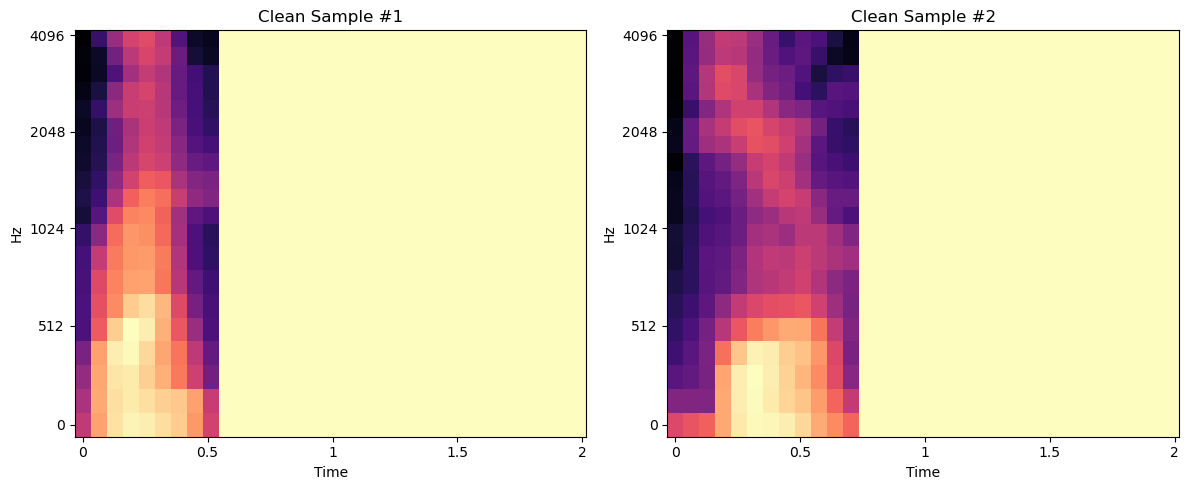

In [336]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(specs[3001], sr=8000, hop_length=512,
                         x_axis='time', y_axis='mel')
plt.title('Clean Sample #1')

plt.subplot(1, 2, 2)

librosa.display.specshow(specs[5], sr=8000, hop_length=512,
                         x_axis='time', y_axis='mel')
plt.title('Clean Sample #2')

plt.tight_layout()
plt.show()

In [3]:
from sklearn.preprocessing import StandardScaler

dim_1 = specs.shape[1]
dim_2 = specs.shape[2]
specs_transposed = specs.reshape(specs.shape[0], dim_2, dim_1)
print("Transposed features shape:", specs_transposed.shape)

X_train, X_test, y_train, y_test = train_test_split(
    specs_transposed, labels, test_size=3000, random_state=42
)

n_train, n_mels, n_steps = X_train.shape
n_test = X_test.shape[0]

X_train_flat = X_train.reshape(n_train, -1)   
X_test_flat  = X_test .reshape(n_test , -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)

X_test_scaled = scaler.transform(X_test_flat)

X_train_scaled = X_train_scaled.reshape(n_train, n_mels, n_steps)
X_test_scaled  = X_test_scaled .reshape(n_test , n_mels, n_steps)

print("features_train shape:", X_train_scaled.shape)
print("labels_train shape:", y_train.shape)
print("features_test shape:", X_train_scaled.shape)
print("labels_test shape:", y_test.shape)

import joblib
joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved to scaler.joblib")

Transposed features shape: (30000, 32, 20)
features_train shape: (27000, 32, 20)
labels_train shape: (27000, 10)
features_test shape: (27000, 32, 20)
labels_test shape: (3000, 10)
Scaler saved to scaler.joblib


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 32, 16)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,154 (39.66 KB)

 Trainable params: 10,090 (39.41 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4817 - loss: 1.5045 - val_accuracy: 0.8613 - val_loss: 0.4270
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8494 - loss: 0.4698 - val_accuracy: 0.9190 - val_loss: 0.2615
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9053 - loss: 0.3032 - val_accuracy: 0.9410 - val_loss: 0.1825
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9257 - loss: 0.2344 - val_accuracy: 0.9467 - val_loss: 0.1649
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9414 - loss: 0.1910 - val_accuracy: 0.9563 - val_loss: 0.1303
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9505 - loss: 0.1616 - val_accuracy: 0.9660 - val_loss: 0.1128
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9575 - loss: 0.1448 - val_accuracy: 0.9660 - val_loss: 0.1003
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9599 - loss: 0.1320 - 

Validation Loss: 0.0500
Validation Accuracy: 0.9877
Model saved to logmel_lstm_digit_classifier.h5


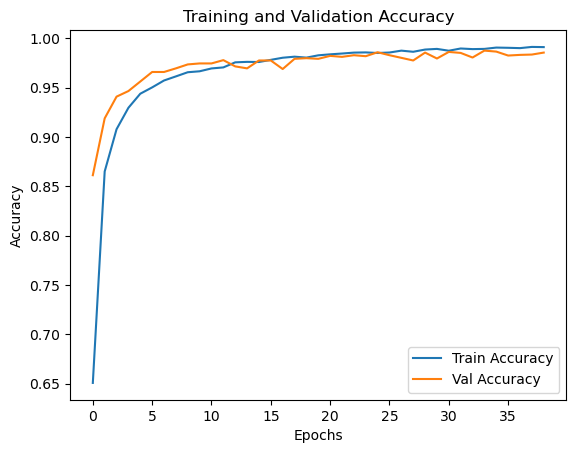

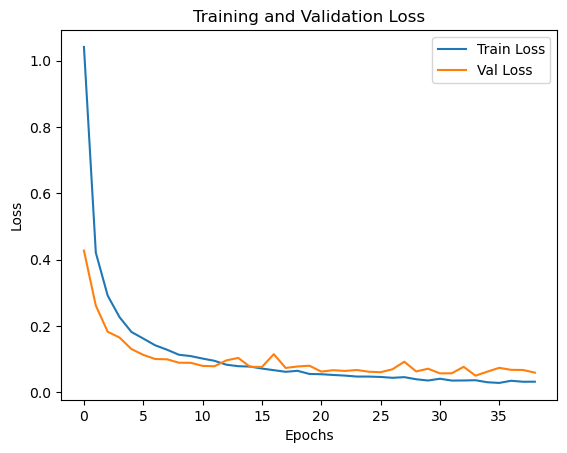

In [245]:
model = Sequential()
model.add(layers.Input(shape=(32, 20)))
#model.add(layers.LSTM(64, return_sequences = True))

model.add(layers.LSTM(16, return_sequences = True))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

val_loss, val_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

model_save_path = 'logmel_lstm_digit_classifier.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [246]:
loaded_model = load_model(model_save_path)

predictions = loaded_model.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report on Test Data:")
print(classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(10)]))

accuracy = np.mean(predicted_labels == true_labels)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

print(f"Sample Predicted labels: {predicted_labels[:50]}...")
print(f"Sample True labels:      {true_labels[:50]}...")


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       279
           1       1.00      0.99      0.99       304
           2       0.99      1.00      0.99       301
           3       0.99      0.99      0.99       338
           4       0.99      1.00      0.99       308
           5       0.98      0.98      0.98       309
           6       0.99      1.00      0.99       274
           7       0.96      0.98      0.97       306
           8       0.99      0.98      0.99       289
           9       0.98      0.98      0.98       292

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Final Test Accuracy: 0.9877
Sample Predicted labels: [0 7 7 8 0 2 1 2 3 6 3 7 1 5 4 4 9 4 8 4 5 1 2 2 3 7 5 1 7 1 9 9 7 2 7 6 9
 3 7 4 1 2 8 6 1 4 2 0 0 2]...
Sampl

Recording for 1.0 second(s)... Speak now!
Recording saved as recorded_audio_cell.wav
Trimmed audio saved as trimmed_audio.wav
Processing trimmed_audio.wav for prediction...
Loading pre-trained model...
Predicting digit...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step

--->>> PREDICTED DIGIT: 4


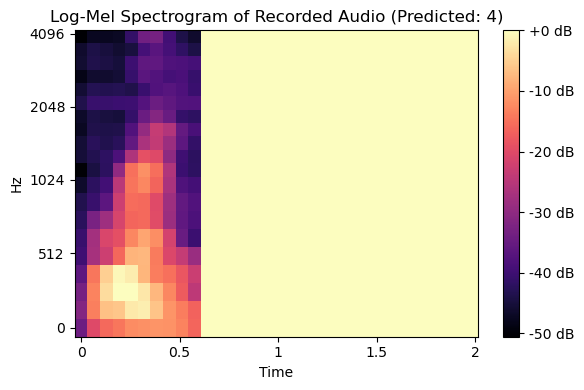

In [347]:
import sounddevice as sd
from scipy.io.wavfile import write as write_wav
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
import librosa
import librosa.display 

def trim_silence(audio_data, sr, threshold_db=-15, min_silence_duration=0.1):
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]
    
    amplitude = np.abs(audio_data)
    max_amplitude = np.max(amplitude)
    if max_amplitude > 0:
        # Add small epsilon to prevent divide by zero
        db = 20 * np.log10(np.maximum(amplitude, 1e-10) / max_amplitude)
    else:
        return audio_data
    
    non_silence = db > threshold_db
    
    non_silence_frames = np.where(non_silence)[0]
    if len(non_silence_frames) > 0:
        start_idx = non_silence_frames[0]
        end_idx = non_silence_frames[-1] + 1
        
        buffer_samples = int(min_silence_duration * sr)
        start_idx = max(0, start_idx - buffer_samples)
        end_idx = min(len(audio_data), end_idx + buffer_samples)
        
        return audio_data[start_idx:end_idx]
    else:
        return audio_data

def stretch_to_duration(wave, orig_sr, target_duration=0.5):
    target_length = int(target_duration * orig_sr)
    current_length = len(wave)
    
    if current_length == 0:
        return np.zeros(target_length)
    
    if current_length < target_length:
        return librosa.effects.time_stretch(wave, rate=current_length/target_length)
    else:
        return librosa.effects.time_stretch(wave, rate=current_length/target_length)

def wav2logmelspec2(file_path, max_pad_len=32):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    #wave = stretch_to_duration(wave, orig_sr=sr, target_duration=0.75)
    wave = librosa.resample(wave, orig_sr=sr, target_sr=8000) 
    melspec = librosa.feature.melspectrogram(y=wave,
                                             sr=8000,
                                             n_fft=2048,
                                             hop_length=512,
                                             n_mels=20)
    log_mel_spec = librosa.power_to_db(melspec, ref=np.max)

    current_len = log_mel_spec.shape[1]
    if current_len > max_pad_len:
        log_mel_spec = log_mel_spec[:, :max_pad_len]
    elif current_len < max_pad_len:
        pad_width = max_pad_len - current_len
        log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return log_mel_spec

def record_audio_for_notebook_cell(duration_sec=1, rate_hz=48000, output_filename="recorded_audio_cell.wav"):
    print(f"Recording for {duration_sec} second(s)... Speak now!")
    audio_recording = sd.rec(int(duration_sec * rate_hz), samplerate=rate_hz, channels=1, dtype='float32')
    sd.wait()
    write_wav(output_filename, rate_hz, audio_recording)
    print(f"Recording saved as {output_filename}")
    return output_filename, audio_recording

def trim_and_save_audio(audio_data, sr, output_filename="trimmed_audio.wav"):
    trimmed_audio = trim_silence(audio_data, sr)
    write_wav(output_filename, sr, trimmed_audio)
    print(f"Trimmed audio saved as {output_filename}")
    return output_filename

def preprocess_single_audio_for_model(audio_file_path_str, scaler_object, model_steps=32, model_mels=20):
    log_mel_spectrogram = wav2logmelspec2(audio_file_path_str) 
    flattened_log_mel = log_mel_spectrogram.reshape(1, -1)
    scaled_flattened_log_mel = scaler_object.transform(flattened_log_mel)
    model_input_shape_tuple = (1, model_steps, model_mels) 
    final_processed_audio = scaled_flattened_log_mel.reshape(model_input_shape_tuple)
    return final_processed_audio, log_mel_spectrogram 

def predict_digit_from_audio_cell(audio_file_path_str, model_file_path_str, scaler_object):
    print(f"Processing {audio_file_path_str} for prediction...")
    processed_model_features, raw_log_mel_spec_for_plot = preprocess_single_audio_for_model(audio_file_path_str, scaler_object, model_steps=32, model_mels=20)
    
    print("Loading pre-trained model...")
    keras_model = load_model(model_file_path_str, compile=False) 

    print("Predicting digit...")
    model_prediction = keras_model.predict(processed_model_features)
    predicted_class_index = np.argmax(model_prediction, axis=1)[0]
    
    return predicted_class_index, raw_log_mel_spec_for_plot, processed_model_features

filename_of_recording, audio_data = record_audio_for_notebook_cell(duration_sec=1.0)
trimmed_filename = trim_and_save_audio(audio_data, sr=48000)
result_predicted_digit, spectrogram_to_plot, processed_features = predict_digit_from_audio_cell(trimmed_filename, model_save_path, scaler)

print(f"\n--->>> PREDICTED DIGIT: {result_predicted_digit}")

plt.figure(figsize=(6, 4))
librosa.display.specshow(spectrogram_to_plot, sr=8000, hop_length=512, x_axis='time', y_axis='mel')
plt.title(f'Log-Mel Spectrogram of Recorded Audio (Predicted: {result_predicted_digit})')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()